# State Farm Distracted Driver Detection: Revisited
_Can computer vision spot distracted drivers?_

---

## Lesson 2 Homework Assignment

"Try to set up the data, train a model, and submit your predictions for this competition using only code that you write from scratch. If you look at the code provided for the class to get help, don't copy and paste it - but instead read the source code for vgg16.py and utils.py, and the keras documentation, and try to write and debug your own version"

Dataset: https://www.kaggle.com/c/state-farm-distracted-driver-detection

In [39]:
import os
from glob import glob

current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data/statefarm/'

# point to your training images
train_dir = DATA_HOME_DIR + 'train'

# point to the 'driver_imgs_list.csv'
lookup = DATA_HOME_DIR + 'driver_imgs_list.csv'

# point to the validation directory, which will be created in the next block
val_dir = DATA_HOME_DIR + 'valid'

sample_dir = DATA_HOME_DIR + 'sample'

test_dir = DATA_HOME_DIR + 'test'

### Download dataset using the [Kaggle CLI](http://wiki.fast.ai/index.php/Kaggle_CLI):

After running `kg config -g -u <username> -p <password> -c state-farm-distracted-driver-detection`

**Careful**: the `unzip` process tends to freeze the Jupyter environment... it's actually safer to just run `unzip` on the command line. This is here more as an example of entirely documenting a data process.

In [ ]:
%cd $DATA_HOME_DIR

In [ ]:
!kg download
!unzip sample_submission.csv.zip
!unzip imgs.zip
!unzip driver_imgs_list.csv.zip

Unzipped contents:
1. `sample_submission.csv`
2. `driver_imgs_list.csv`
3. `test/`: 79726 images (`ls test/ | wc -l`)
4. `train/`: 22424 images
    - `c0/`: 2489; `c1/`: 2267; `c2/`: 2317; `c3/`: 2346; `c4/`: 2326; `c5/`: 2312; `c6/`: 2325; `c7/`: 2002; `c8/`: 1911; `c9/`: 2129

In [ ]:
%cd $train_dir
printNumImages = 'Train file count by class: '
for d in sorted(glob('c?')):
    numImgs = !ls "$train_dir"/"$d"/ | wc -l
    printNumImages += d + ': ' + str(numImgs[0]) + '; '
print printNumImages

In [ ]:
%cd $LESSON_HOME_DIR

### Create the validation set ([help](http://forums.fast.ai/t/how-to-create-the-state-farm-comp-validation-set/1306)):

Aiming for 20% of the training set.

Remember that the training and validation set should contain _different drivers_, as mentioned on the Kaggle competition page.

In [2]:
import random
import pandas as pd
import numpy as np

In [ ]:
# creates a directory, called 'valid', and into it, creates 10 subdirs, one for each class.

if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    %cd $train_dir
    for d in glob('c?'):
        os.mkdir(val_dir + '/' + d)
    # read in the 'driver_imgs_list.csv' file
    df = pd.read_csv(lookup)
    # Pick 20% (1/5) of the drivers at random
    drivers = df.subject.unique()
    driver_names_for_validation = random.sample(drivers, drivers.size / 5)
    # filter df by selecting rows with the drivers (subjects) we want
    df = df[df['subject'].isin(driver_names_for_validation)]
    # do the move here:
    filesMoved = 0
    for index, row in df.iterrows():
        move_from = train_dir + '/' +  row['classname'] + '/' + row['img']
        move_to = val_dir + '/' +  row['classname'] + '/' + row['img']
        os.rename(move_from, move_to)
        filesMoved += 1
    print 'files to move: ', df.shape[0]
    print 'files moved:   ', filesMoved

%cd $val_dir
printNumImages = 'Valid file count: '
for d in sorted(glob('c?')):
    numImgs = !ls "$val_dir"/"$d"/ | wc -l
    printNumImages += d + ': ' + str(numImgs[0]) + '; '
print printNumImages

%cd $LESSON_HOME_DIR

### Create the sample set ([help](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm-sample.ipynb))

In [ ]:
from shutil import copyfile

if not os.path.exists(sample_dir + '/train'):
    os.makedirs(sample_dir + '/train')
    %cd $train_dir
    for d in glob('c?'):
        os.mkdir(sample_dir + '/train/' + d)
    g = glob('c?/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(1500): copyfile(shuf[i], sample_dir + '/train/' + shuf[i])

if not os.path.exists(sample_dir + '/valid'):
    os.makedirs(sample_dir + '/valid')
    %cd $val_dir
    for d in glob('c?'):
        os.mkdir(sample_dir + '/valid/' + d)
    g = glob('c?/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(1000): copyfile(shuf[i], sample_dir + '/valid/' + shuf[i])
        
%cd $LESSON_HOME_DIR

### Move the test set to 'unknown' directory
Represents the single 'unknown' class for the test set - needed for submission later

In [47]:
if not os.path.exists(test_dir + '/unknown'):
    os.makedirs(test_dir + '/unknown')
    %cd $test_dir
    for img in glob('*.jpg'):
        os.rename(test_dir + '/' + str(img), test_dir + '/unknown/' + str(img))

/home/ubuntu/hmwk/nbs/data/statefarm/test


### Basic Configuration

In [3]:
%matplotlib inline

In [4]:
#path = DATA_HOME_DIR + 'sample/'
path = DATA_HOME_DIR
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [5]:
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [6]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [7]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Keras returns classes as a single column, so we convert to one hot encoding

In [8]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

A simple function for fitting models that saves us a little typing

In [9]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

### Prepare the data


Our overall approach here will be:
1. Get the true labels for every image
2. Finetune the model by replacing the final linear layer that mapped input to 1,000 imagenet category predictions with a final linear layer that maps input to 10 StateFarm category predictions
3. Fit the model by re-training the new final linear layer w.r.t. the true labels from step 1.

In [10]:
# Import Vgg16, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

vgg = Vgg16()
model = vgg.model

Grab training and validation batches...

In [11]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_preprocess = get_batches(path+'valid', shuffle=False, batch_size=1)
trn_preprocess = get_batches(path+'train', shuffle=False, batch_size=1)

Found 4126 images belonging to 10 classes.
Found 18298 images belonging to 10 classes.


Let's look at the class data for these batches, in both single-column and one-hot encoded forms

In [12]:
val_classes = val_preprocess.classes
trn_classes = trn_preprocess.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [13]:
trn_classes.shape, trn_labels.shape

((18298,), (18298, 10))

In [14]:
trn_classes[:4], trn_labels[:4]

(array([0, 0, 0, 0], dtype=int32),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

Now we have the labels. Let's get the datasets we want to predict on next.

Note that `get_data` runs `get_batches` and then concatenates the arrays from all the batches

In [ ]:
??get_data

In [15]:
trn_data_path = model_path+'train_data.bc';
val_data_path = model_path+'valid_data.bc';

if os.path.exists(trn_data_path):
    trn_data = load_array(trn_data_path)
else:
    trn_data = get_data(path+'train')
    save_array(trn_data_path, trn_data)
    
if os.path.exists(val_data_path):
    val_data = load_array(val_data_path)
else:
    val_data = get_data(path+'valid')
    save_array(val_data_path, val_data)

Found 18298 images belonging to 10 classes.
Found 4126 images belonging to 10 classes.


`.shape` here represents (num_images, num_colors (RGB=3), width_in_pixels, height_in_pixels).

In [16]:
trn_data.shape, val_data.shape

((18298, 3, 224, 224), (4126, 3, 224, 224))

### Finetuning for State Farm

If we take a look at our Vgg model, we'll see that the final layer is a dense.

In [17]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

The final dense layer is what mapped the final intermediate layer to the categories specified by the ImageNet competition. Since we'd like to map to different categories, let's replace this final dense layer with our own (this is what _finetuning_ essentially is!)

In [ ]:
??vgg.finetune

In [18]:
model.pop()
for layer in model.layers: layer.trainable=False

Note that we fix the weights in all the remaining layers by setting `layer.trainable=False` - we aren't looking to learn new parameters for these others, only our new linear layer.

### Train linear model on predictions

In [19]:
model.add(Dense(10, activation='softmax'))

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Time to set our batches to use the preprocessed images and layers prepped earlier (_shuffling_ the training batches this time to add more randomness in our epochs), compile our updated model, and fit the last layer of the model.

In [21]:
gen=image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [22]:
opt = Adam()
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
fit_model(model, trn_batches, val_batches, nb_epoch=3)

Epoch 1/3
18298/18298 [==============================] - 541s - loss: 1.8822 - acc: 0.4769 - val_loss: 1.7038 - val_acc: 0.4767
Epoch 2/3
18298/18298 [==============================] - 542s - loss: 0.9822 - acc: 0.6849 - val_loss: 1.8349 - val_acc: 0.4673
Epoch 3/3
18298/18298 [==============================] - 542s - loss: 0.8670 - acc: 0.7205 - val_loss: 1.8553 - val_acc: 0.4753


Save weights now for reuse.

In [25]:
finetune1_path = model_path+'finetune1.h5'
if not os.path.exists(finetune1_path):
    model.save_weights(finetune1_path)
model.load_weights(finetune1_path)

### Finetuning Multiple Layers

Finetuning from the first dense layer, on.

Note that since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously ([source](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson2.ipynb)).

In [26]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True
K.set_value(opt.lr, 0.0001)
fit_model(model, trn_batches, val_batches, nb_epoch=2)

Epoch 1/5
18298/18298 [==============================] - 540s - loss: 0.7230 - acc: 0.7629 - val_loss: 1.7471 - val_acc: 0.4867
Epoch 2/5
18298/18298 [==============================] - 541s - loss: 0.6709 - acc: 0.7754 - val_loss: 1.6759 - val_acc: 0.5133
Epoch 3/5
18298/18298 [==============================] - 542s - loss: 0.6635 - acc: 0.7810 - val_loss: 1.7522 - val_acc: 0.4879
Epoch 4/5
18298/18298 [==============================] - 542s - loss: 0.6430 - acc: 0.7831 - val_loss: 1.6603 - val_acc: 0.4995
Epoch 5/5
18298/18298 [==============================] - 542s - loss: 0.6260 - acc: 0.7907 - val_loss: 1.6719 - val_acc: 0.4978


Save weights now for reuse.

In [27]:
finetune2_path = model_path+'finetune2.h5'
if not os.path.exists(finetune2_path):
    model.save_weights(finetune2_path)
model.load_weights(finetune2_path)

### Evaluation

In [29]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

4126/4126 [==============================] - 100s   


array([ 0.6769,  0.5376,  0.9404,  0.708 ,  0.8352,  0.9502,  0.8674,  0.8622], dtype=float32)

In [31]:
cm = confusion_matrix(val_classes, preds)

Class names provided by: https://www.kaggle.com/c/state-farm-distracted-driver-detection#evaluation
- c0: normal driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

[[359   5   5  12  18  12   0   0  14  63]
 [ 93 128  15  17  10   7  44  64  28   8]
 [ 36   4 280   0   2   0   9   1  92   0]
 [ 46   5  20 237  38  14   9  23  35  21]
 [131   5  58  14 118   4  39  21  42  17]
 [ 53  10   0   5   7 342   6   0  23   3]
 [ 46  10   4  10  42   3 139  48 110   7]
 [ 75   9  15   1   4   7   1 251  26   0]
 [ 56   6   7   9  23   4   6   0 177  17]
 [ 91  10  18   4  41   9  23  62  60  23]]


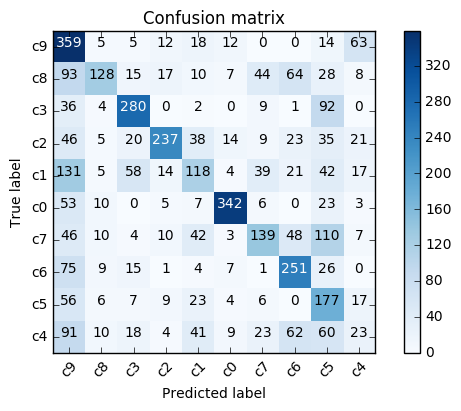

In [32]:
plot_confusion_matrix(cm, val_preprocess.class_indices)

### Iteration Record

**Iteration #1 results:**

`Epoch 1/3
18104/18104 [==============================] - 550s - loss: 14.0563 - acc: 0.1247 - val_loss: 13.8792 - val_acc: 0.1377
Epoch 2/3
18104/18104 [==============================] - 551s - loss: 13.7498 - acc: 0.1464 - val_loss: 14.1173 - val_acc: 0.1241
Epoch 3/3
18104/18104 [==============================] - 550s - loss: 13.7294 - acc: 0.1471 - val_loss: 13.6851 - val_acc: 0.1498`

**Confusion matrix:**

`c9 [[395   0   0   0   0   0   0  62   0   0]
 c8 [279   0   0   0   0   0   0 193   0   0]
 c3 [302   0  10   0   0   0   0 152   0   0]
 c2 [406   0   0   0   0   0   0  58   0   0]
 c1 [366   0   0   0   0   0   0 106   0   0]
 c0 [265   0   0   0   0   0   0 209   0   0]
 c7 [305   0   0   0   0   0   0 142   0   0]
 c6 [144   0   0   0   0   0   0 242   0   0]
 c5 [207   0  11   0   0   0   0 119   0   0]
 c4 [276   0   1   0   0   0   0  70   0   0]]
 -- c9 c8 c3 c2 c1 c0 c7 c6 c5 c4`

These results are much poorer than I was expecting. Strange how:
1. The majority the predictions fall into 2/10 categories, c9 and c6
2. The probabilities are frequently 0 or 1 (perhaps clipping would help?)
3. Accuracy is >10%, which suggests that some training is happening... just not enough

**To improve, I am revisiting:**

**Idea 1.** Dataset creation - did I do something wrong when creating train, valid, sample? 
- Double-checking methodology and then re-creating data splits did not improve results on _sample_
   
**Idea 2.** np.clip?
- Revisiting [Dogs Cats Redux](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/dogs_cats_redux.ipynb) from lesson 1, clipping is something done before submission to Kaggle to hedge against extreme certainty - this isn't enough to explain how poor results are
    
**Idea 3.** Learning rate?
- Lowering it seemed to have no effect on _sample_
    
**Idea 4.** Remove finetuning?
- Removing `model.pop` actually did seem to help..??

**Iteration #2 (remove `model.pop`) results:**

`Epoch 1/3
1500/1500 [==============================] - 60s - loss: 2.2872 - acc: 0.1427 - val_loss: 2.2926 - val_acc: 0.1150
Epoch 2/3
1500/1500 [==============================] - 60s - loss: 2.2174 - acc: 0.1840 - val_loss: 2.2827 - val_acc: 0.1250
Epoch 3/3
1500/1500 [==============================] - 60s - loss: 2.1898 - acc: 0.1960 - val_loss: 2.2387 - val_acc: 0.1900`

At first, really not sure why. Thinking about it more, perhaps this problem benefits more from the 'funneling' that the original final dense layer provides by labelling the 1000 categories. From lesson 1, I recall the `seat_belt` label heavily dominating the image categorization for this dataset.

Even with this improvement, results are half what they were in lesson 1.

**Idea 5.** RMSprop(lr=0.1) => Adam(lr=0.001)?
- Got this idea after looking at the code behind `vgg.finetune` in lesson 1.  That uses Adam instead of RMSprop. This provided the most promising boost so far.

**Iteration #3 (use `Adam(lr=0.001)` optimizer) results:**

`Epoch 1/3
1500/1500 [==============================] - 60s - loss: 3.8602 - acc: 0.1427 - val_loss: 2.1919 - val_acc: 0.3040
Epoch 2/3
1500/1500 [==============================] - 60s - loss: 2.8074 - acc: 0.2807 - val_loss: 2.0083 - val_acc: 0.3390
Epoch 3/3
1500/1500 [==============================] - 61s - loss: 2.2858 - acc: 0.3767 - val_loss: 2.0740 - val_acc: 0.3570`

This significant perfomance improvement is pretty frustrating, as differences between the various optimizers used for gradient descent have not been covered yet. I was using `RMSprop` like the `lesson2.ipynb` notebook from the course materials, on the faith that it is a good default. Perhaps my mistake was assuming that because it's a good default for cats vs dogs, it translates to this competition... but there's a lot of assuming going on so early in this course right now, so how to choose which assumptions to question? Feels like a big downside of top-down learning.

**Idea 6.** Finetuning multiple layers, starting with the first dense layer
- The fact that now my `val_acc >> acc` is interesting... I saw it [hypothesized in the forums](http://forums.fast.ai/t/approach-to-debugging-a-woeful-model/3334?u=iconix) that this could mean I'm still underfitting the data, which makes intuitive sense to me. So, let's try out another technique introduced in the course materials, while adding more training epochs.

**Iteration #4 (finetune multiple layers) results:**

`Epoch 1/3
1500/1500 [==============================] - 61s - loss: 2.7465 - acc: 0.4627 - val_loss: 2.7878 - val_acc: 0.3720
Epoch 2/3
1500/1500 [==============================] - 61s - loss: 1.8657 - acc: 0.5520 - val_loss: 2.4985 - val_acc: 0.3820
Epoch 3/3
1500/1500 [==============================] - 61s - loss: 1.6960 - acc: 0.5507 - val_loss: 2.2490 - val_acc: 0.3940`

Now to test these improvements outside of the _sample_ dataset...

`Epoch 1/3
18298/18298 [==============================] - 541s - loss: 1.8822 - acc: 0.4769 - val_loss: 1.7038 - val_acc: 0.4767
Epoch 2/3
18298/18298 [==============================] - 542s - loss: 0.9822 - acc: 0.6849 - val_loss: 1.8349 - val_acc: 0.4673
Epoch 3/3
18298/18298 [==============================] - 542s - loss: 0.8670 - acc: 0.7205 - val_loss: 1.8553 - val_acc: 0.4753`

`Epoch 1/2
18298/18298 [==============================] - 540s - loss: 0.7230 - acc: 0.7629 - val_loss: 1.7471 - val_acc: 0.4867
Epoch 2/2
18298/18298 [==============================] - 541s - loss: 0.6709 - acc: 0.7754 - val_loss: 1.6759 - val_acc: 0.5133`

`c9 [[359   5   5  12  18  12   0   0  14  63]
 c8 [ 93 128  15  17  10   7  44  64  28   8]
 c3 [ 36   4 280   0   2   0   9   1  92   0]
 c2 [ 46   5  20 237  38  14   9  23  35  21]
 c1 [131   5  58  14 118   4  39  21  42  17]
 c0 [ 53  10   0   5   7 342   6   0  23   3]
 c7 [ 46  10   4  10  42   3 139  48 110   7]
 c6 [ 75   9  15   1   4   7   1 251  26   0]
 c5 [ 56   6   7   9  23   4   6   0 177  17]
 c4 [ 91  10  18   4  41   9  23  62  60  23]]
 -- c9 c8 c3 c2 c1 c0 c7 c6 c5 c4`

OK, at least these results are now comparable to lesson 1 again. The confusion matrix is also much more diagonal, which is good.

### Submission to Kaggle ([help](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm.ipynb))

_Note on file structure_: I needed to create a single 'unknown' class for the test set

In [54]:
from IPython.display import FileLink

subm_name = 'subm_hmwk2.gz'
subm_path = path + 'results/' + subm_name

In [34]:
#Get the classes from the training batch
classes = sorted(trn_preprocess.class_indices, key=trn_preprocess.class_indices.get)

In [38]:
??vgg.test

In [48]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size*2)

Found 79726 images belonging to 1 classes.


In [50]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the directories.
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  2.1216e-02   9.3973e-04   1.9276e-04   2.6112e-03   8.2366e-03   1.4723e-01   5.5109e-02
    1.5427e-02   1.5991e-01   5.8913e-01]
 [  2.0792e-01   8.2813e-02   1.4909e-04   4.4530e-02   2.5656e-03   2.4723e-02   3.9796e-02
    4.9158e-03   5.5308e-01   3.9504e-02]
 [  4.7711e-03   6.4377e-04   1.8179e-01   1.8949e-02   3.3458e-01   1.4237e-02   2.6641e-01
    9.0478e-06   1.7711e-01   1.5052e-03]
 [  1.2933e-04   5.8872e-04   4.3073e-02   4.0332e-05   3.5615e-04   7.7359e-05   4.8769e-02
    2.0808e-04   9.0168e-01   5.0736e-03]
 [  2.2983e-02   1.1304e-02   3.5941e-02   2.7033e-04   4.7592e-03   1.3044e-02   5.3175e-01
    3.8694e-03   3.4989e-01   2.6185e-02]]
['unknown/img_81601.jpg', 'unknown/img_14887.jpg', 'unknown/img_62885.jpg', 'unknown/img_45125.jpg', 'unknown/img_22633.jpg']


In [52]:
submission = pd.DataFrame(preds, columns=classes)
submission.insert(0, 'img', [a[8:] for a in filenames])
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_81601.jpg,0.021216,0.000940,0.000193,0.002611,0.008237,0.147230,0.055109,0.015427,0.159907,0.589131
1,img_14887.jpg,0.207924,0.082813,0.000149,0.044530,0.002566,0.024723,0.039796,0.004916,0.553081,0.039504
2,img_62885.jpg,0.004771,0.000644,0.181791,0.018949,0.334576,0.014237,0.266413,0.000009,0.177105,0.001505
3,img_45125.jpg,0.000129,0.000589,0.043073,0.000040,0.000356,0.000077,0.048769,0.000208,0.901684,0.005074
4,img_22633.jpg,0.022983,0.011304,0.035941,0.000270,0.004759,0.013044,0.531753,0.003869,0.349892,0.026185


In [55]:
submission.to_csv(subm_path, index=False, compression='gzip')

In [56]:
FileLink(subm_path)

/home/ubuntu/hmwk/nbs/data/statefarm/results/subm_hmwk2.gz

Then, using the Kaggle CLI:

In [57]:
!kg submit $subm_path -c state-farm-distracted-driver-detection

OSError: [Errno 12] Cannot allocate memory

My **multiclass loss** private score on submission is 1.44900 - still an "ok-ish" top 45% (645/1440).

### Clipping Results Before Submission

In [77]:
subm_name = 'subm5_hmwk2.gz'
subm_path = path + 'results/' + subm_name

In [78]:
clipped_preds = preds.clip(min=0.00625, max=0.99375)

In [79]:
clipped_subm = pd.DataFrame(clipped_preds, columns=classes)
clipped_subm.insert(0, 'img', [a[8:] for a in filenames])
clipped_subm.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_81601.jpg,0.021216,0.006250,0.006250,0.006250,0.008237,0.147230,0.055109,0.015427,0.159907,0.589131
1,img_14887.jpg,0.207924,0.082813,0.006250,0.044530,0.006250,0.024723,0.039796,0.006250,0.553081,0.039504
2,img_62885.jpg,0.006250,0.006250,0.181791,0.018949,0.334576,0.014237,0.266413,0.006250,0.177105,0.006250
3,img_45125.jpg,0.006250,0.006250,0.043073,0.006250,0.006250,0.006250,0.048769,0.006250,0.901684,0.006250
4,img_22633.jpg,0.022983,0.011304,0.035941,0.006250,0.006250,0.013044,0.531753,0.006250,0.349892,0.026185


In [80]:
clipped_subm.to_csv(subm_path, index=False, compression='gzip')

In [81]:
FileLink(subm_path)

/home/ubuntu/hmwk/nbs/data/statefarm/results/subm5_hmwk2.gz

Clipping results:
- 0.05 < p < 0.95: worse (`loss=1.47351`)
- 0.025 < p < 0.975: better (`loss=1.42585`)
- 0.0125 < p < 0.9875: better (`loss=1.41758`)
- 0.00625 < p < 0.99375: better (`loss=1.41526`, 638/1440=top 44%)

A modest improvement on my leaderboard position in lesson 1.